In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datasets
from codetrace.type_inf_exp.build_dataset import *
import json

In [20]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/home/arjun/models/starcoderbase-1b")

['variation', 'a']

In [5]:
comp_ds = datasets.load_dataset("franlucc/ts_bench_starcoder1b_funcfim_incorrect_uniq_v1", split="train")

In [6]:
comp_ds[0]

{'generated_text': '0',
 'fim_sol': '1',
 'success': False,
 'prompt': '<fim_prefix>declare var require: any;\nconst assert = require("node:assert");\ntype _uniq_0 = { kind: "Ctor2" } | { kind: "Ctor3" };\ntype _uniq_1 =\n  | { kind: "Ctor4"; f0: _uniq_0 }\n  | { kind: "Ctor5"; f0: _uniq_1 }\n  | { kind: "Ctor6"; f0: _uniq_1; f1: _uniq_1 }\n  | { kind: "Ctor7"; f0: _uniq_1; f1: _uniq_1 }\n  | { kind: "Ctor8"; f0: _uniq_1; f1: _uniq_1 };\n\nfunction _uniq_9(_uniq_13: _uniq_0): _uniq_0 {\n  switch (_uniq_13.kind) {\n    case "Ctor2": {\n      return { kind: "Ctor3" };\n    }\n    case "Ctor3": {\n      return { kind: "Ctor2" };\n    }\n  }\n}\nfunction _uniq_10(_uniq_14: _uniq_0): (_uniq_15: _uniq_0) => _uniq_0 {\n  return function (_uniq_15: _uniq_0) {\n    switch (_uniq_15.kind) {\n      case "Ctor2": {\n        return _uniq_14;\n      }\n      case "Ctor3": {\n        return { kind: "Ctor3" };\n      }\n    }\n  };\n}\nfunction _uniq_11(_uniq_16: _uniq_0): (_uniq_17: _uniq_0) => _uniq

In [6]:
programs = []
for ex in comp_ds:
    prompt = ex["prompt"]
    placeholder_prompt = std_to_placeholder_fmt(prompt, STARCODER_FIM)
    prog = placeholder_prompt.replace("<FILL>", ex["generated"].strip())
    programs.append(prog)

In [10]:
for i,p in enumerate(programs):
    with open(f"exp_data/programs/program_{i}.ts", "w") as f:
        f.write(p)

In [4]:
incorrect = comp_ds.filter(lambda x: x["correctness"] == "incorrect")
correct = comp_ds.filter(lambda x: x["correctness"] == "correct")
correct_number = correct.filter(lambda x: x["solution"] == "number")

In [5]:
incorrect, correct, correct_number

(Dataset({
     features: ['generated', 'solution', 'hexsha', 'prompt', 'correctness', 'id'],
     num_rows: 1220
 }),
 Dataset({
     features: ['generated', 'solution', 'hexsha', 'prompt', 'correctness', 'id'],
     num_rows: 3311
 }),
 Dataset({
     features: ['generated', 'solution', 'hexsha', 'prompt', 'correctness', 'id'],
     num_rows: 697
 }))

In [6]:
model = "/home/arjun/models/starcoderbase-3b"
model = LanguageModel(model, device_map="cuda:3")
model

GPTBigCodeForCausalLM(
  (transformer): GPTBigCodeModel(
    (wte): Embedding(49152, 2816)
    (wpe): Embedding(8192, 2816)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPTBigCodeBlock(
        (ln_1): LayerNorm((2816,), eps=1e-05, elementwise_affine=True)
        (attn): GPTBigCodeSdpaAttention(
          (c_attn): Linear(in_features=2816, out_features=3072, bias=True)
          (c_proj): Linear(in_features=2816, out_features=2816, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((2816,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTBigCodeMLP(
          (c_fc): Linear(in_features=2816, out_features=11264, bias=True)
          (c_proj): Linear(in_features=11264, out_features=2816, bias=True)
          (act): PytorchGELUTanh()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((2816,), 

## patching on type inf data

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:15<00:00,  3.86s/it]


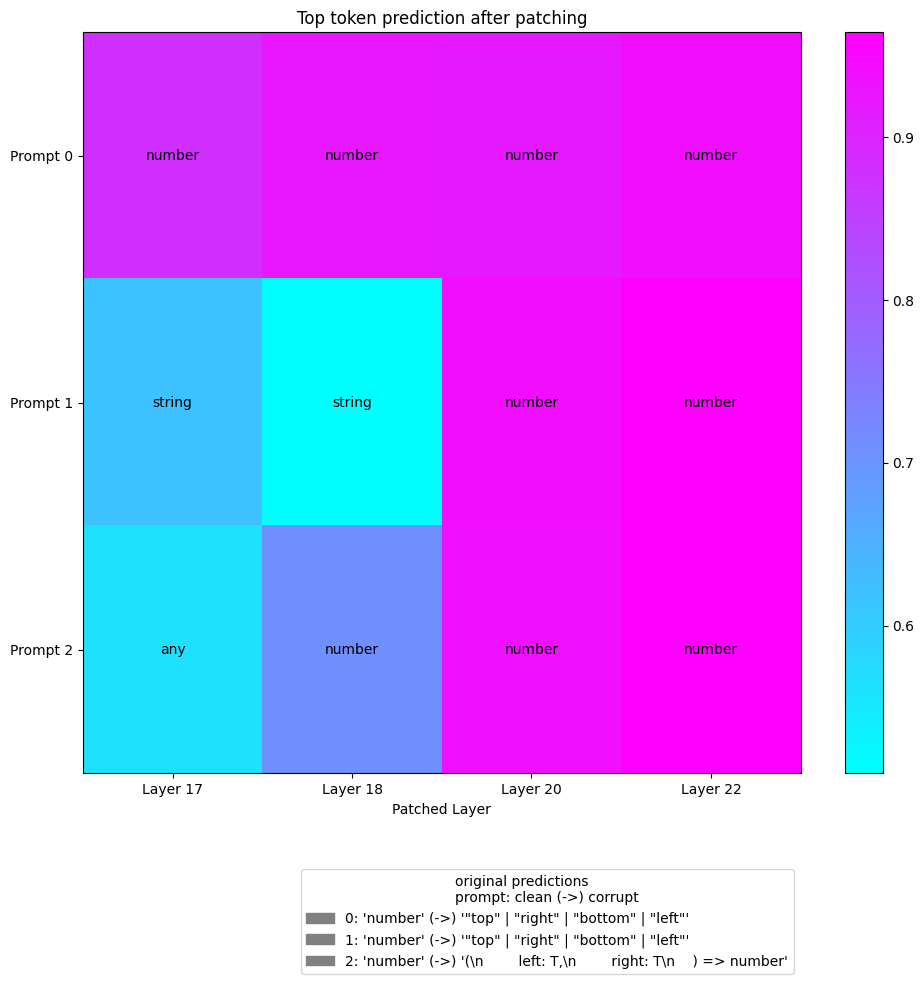

In [8]:
k = range(3)
cleans = [correct_number[i]["prompt"] for i in k]
corrs = [incorrect[i]["prompt"] for i in k]
incorrect_solns = [incorrect[i]["solution"] for i in k]
correct_solns = [correct_number[i]["solution"] for i in k]
annotations = list(zip(correct_solns, incorrect_solns))

patch_l = [17,18,20,22]
trace_results = []
for l in tqdm(patch_l):
    trace_res = patch_clean_to_corrupt(model, cleans, corrs, l)
    trace_results.append(trace_res)

patched_heatmap_prediction(model, cleans,corrs, trace_results, patch_l, 
                           figtitle="Top token prediction after patching", 
                           bbox_to_anchor=(1,-0.2), 
                           annotations=annotations, 
                           outfile = f"patched_3b_pred_k{'-'.join([str(a) for a in k])}_l{'-'.join([str(p) for p in patch_l])}.pdf"
                           )

In [51]:
# make a list of correct-incorrect where correct["solution"]==incorrect["solution"]
correct_incorrect = []
for c in tqdm(correct):
    for i in incorrect:
        if c["solution"] == i["solution"]:
            correct_incorrect.append((c,i))

# with open("../data/correct_incorrect.json", "w") as f:
#     json.dump(correct_incorrect, f)

100%|██████████| 2296/2296 [03:48<00:00, 10.04it/s]


In [8]:
with open("../data/results/correct_incorrect.json", "r") as f:
    correct_incorrect = json.load(f)

  0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/home/franlucc/venvs/gpu/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 3/3 [00:37<00:00, 12.47s/it]


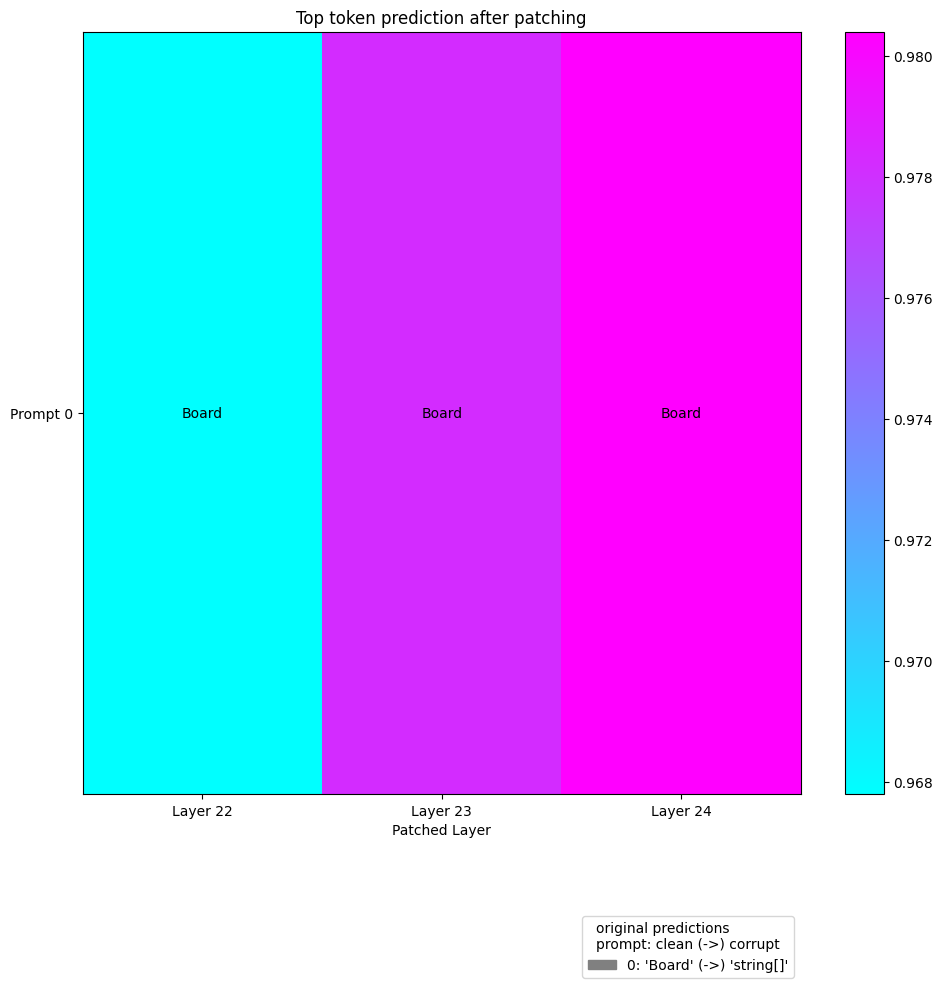

In [9]:
# import random
# seed=0
# random.seed(seed)
# # shuffle
# random.shuffle(correct_incorrect)

k = range(51,52)
cleans = [correct_incorrect[i][0]["prompt"] for i in k]
corrs = [correct_incorrect[i][1]["prompt"] for i in k]
correct_solns = [correct_incorrect[i][0]["solution"] for i in k]
incorrect_gen = [correct_incorrect[i][1]["generated"] for i in k]
annotations = list(zip(correct_solns, incorrect_gen))

patch_l = [22,23,24]
trace_results = []
for l in tqdm(patch_l):
    trace_res = patch_clean_to_corrupt(model, cleans, corrs, l)
    trace_results.append(trace_res)

patched_heatmap_prediction(model, cleans,corrs, trace_results, patch_l, 
                           figtitle="Top token prediction after patching", 
                           bbox_to_anchor=(1,-0.2), 
                           annotations=annotations, 
                           outfile=f"match_patch_3b_{k[0]}_{k[-1]}_layers-{'-'.join(map(str, patch_l))}.pdf"
                           )

## Request patching

In [7]:
from request_patch import *
import random
random.seed(0)
correct_prompts = [c["prompt"] for c in correct]
random.shuffle(correct_prompts)
# avg_tensor = get_averages(model, correct_prompts[:200], STARCODER_FIM.to_list()[:-1], 10)

avg_tensor.shape

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/franlucc/venvs/gpu/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Batch:   0%|          | 0/20 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [8]:
# torch.save(avg_tensor, "_test_3b.pt")
avg_tensor = torch.load("_test_3b.pt")
avg_tensor.shape

torch.Size([36, 2816])

In [9]:
incorrect_prompts = [i for i in incorrect if len(model.tokenizer.tokenize(i["solution"])) == 1]
solns = [i["solution"] for i in incorrect_prompts]

len(incorrect_prompts), len(list(set(solns)))

(330, 52)

In [10]:
unique_files = list(set(files))
unique_types = list(set([i["solution"] for i in incorrect_prompts]))
len(unique_files), len(unique_types)

NameError: name 'files' is not defined

In [11]:
k = [50,52]
# 40, 44
prompts = [i["prompt"] for i in incorrect_prompts[k[0]:k[-1]]]
solns = [i["solution"] for i in incorrect_prompts[k[0]:k[-1]]]
gens = [i["generated"] for i in incorrect_prompts[k[0]:k[-1]]]
solns, gens

(['Q', 'R', 'R'],
 ['Arrow<A, B>\nexport function pipe<A, B, C',
  'A\n\nexport function pipe<A, B, C, D, E',
  'T'])

In [12]:
out = insert_patch(model, prompts, avg_tensor, list(range(16,21)), STARCODER_FIM.to_list()[:-1])
out

OutOfMemoryError: CUDA out of memory. Tried to allocate 54.84 GiB. GPU 3 has a total capacty of 79.11 GiB of which 37.80 GiB is free. Including non-PyTorch memory, this process has 41.30 GiB memory in use. Of the allocated memory 40.10 GiB is allocated by PyTorch, and 628.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
logits : LogitResult = out.decode_logits(prompt_idx=list(range(len(prompts))))
comparison = []
for i,ex in enumerate(incorrect_prompts[k[0]:k[-1]]):
    soln = ex["solution"]
    out_p = logits[-1][i].tokens(model.tokenizer)
    assert len(out_p) == 1
    comparison.append({"solution":soln, "patched":out_p[0], "old":ex["generated"]})
    
print(json.dumps(comparison, indent=2))

[
  {
    "solution": "Arrow",
    "patched": "any",
    "old": "any,\n  ij?: any,\n  jk?: any,\n  kl?:"
  },
  {
    "solution": "Arrow",
    "patched": "any",
    "old": "any,\n  hi?: any\n) {\n  return pipe_(a, ab"
  },
  {
    "solution": "Arrow",
    "patched": ".",
    "old": "any,\n  fg?: any,\n  gh?: any,\n  hi?: any"
  },
  {
    "solution": "Arrow",
    "patched": ".",
    "old": "any,\n  ef?: any,\n  fg?: any,\n  gh?: any"
  }
]


In [21]:
import glob

res = []
for f in glob.glob("../data/results/avg_patching_exp/*.json"):
    with open(f, "r") as f:
        j = json.load(f)
    res += j
    
# assert len(res) == 438, len(res)
# find correct
correct = []
partial_credit = []
anyies = []
for ex in res:
    i = int(ex["i"])
    p = incorrect_prompts[i]["prompt"]
    if ex["patched"] == ex["solution"]:
        correct.append((p,ex))
    elif ex["patched"].lower() == ex["solution"].lower() and ex["solution"].lower() != ex["old"].lower():
        partial_credit.append((p,ex))
    elif ex["solution"] == "any":
        anyies.append((p,ex))
      
ptyp = [j for j in anyies if j[1]["patched"] == "type"]
typ = len(ptyp)
# print(json.dumps(ptyp, indent=2))
print(typ, len(anyies), typ/len(anyies))
print(json.dumps(correct, indent=2))
print(json.dumps(partial_credit, indent=2))
print(json.dumps(anyies, indent=2))
len(correct), len(partial_credit), len(res), len(correct)/len(res), len(partial_credit)/len(res)

IndexError: list index out of range

In [16]:
comparison = []
delta = 1
k = 0
while k+delta < len(incorrect_prompts):
    # do giant loop
    tk = [k, k+delta]
    # 40, 44
    prompts = [i["prompt"] for i in incorrect_prompts[tk[0]:tk[-1]]]
    solns = [i["solution"] for i in incorrect_prompts[tk[0]:tk[-1]]]
    gens = [i["generated"] for i in incorrect_prompts[tk[0]:tk[-1]]]
    out = insert_patch(model, prompts, avg_tensor, list(range(16,23)), STARCODER_FIM.to_list()[:-1])
    logits : LogitResult = out.decode_logits(prompt_idx=list(range(len(prompts))))

    for i,ex in enumerate(incorrect_prompts[tk[0]:tk[-1]]):
        soln = ex["solution"]
        out_p = logits[-1][i].tokens(model.tokenizer)
        assert len(out_p) == 1
        comparison.append({"i":tk[0]+i,"solution":soln, "patched":out_p[0], "old":ex["generated"]})
        
    k += delta
    del(out)
    del(logits)
    
    with open("patched_comparison.json", "w") as f:
        json.dump(comparison, f, indent=4)

KeyboardInterrupt: 

## dataset building

In [3]:
ds = datasets.load_dataset("franlucc/stenotype-eval-dataset", split="train")

In [4]:
f_ds = filter_types_with_idx(ds, QUERY_FUNC_TYPES)
f_ds

Dataset({
    features: ['hexsha', 'size', 'ext', 'lang', 'max_stars_repo_path', 'max_stars_repo_name', 'max_stars_repo_head_hexsha', 'max_stars_repo_licenses', 'max_stars_count', 'max_stars_repo_stars_event_min_datetime', 'max_stars_repo_stars_event_max_datetime', 'max_issues_repo_path', 'max_issues_repo_name', 'max_issues_repo_head_hexsha', 'max_issues_repo_licenses', 'max_issues_count', 'max_issues_repo_issues_event_min_datetime', 'max_issues_repo_issues_event_max_datetime', 'max_forks_repo_path', 'max_forks_repo_name', 'max_forks_repo_head_hexsha', 'max_forks_repo_licenses', 'max_forks_count', 'max_forks_repo_forks_event_min_datetime', 'max_forks_repo_forks_event_max_datetime', 'content', 'avg_line_length', 'max_line_length', 'alphanum_fraction', 'annotation_sites', 'type_definitions', 'loc', 'functions', 'loc_per_function', 'estimated_tokens', 'fim_program', 'fim_type'],
    num_rows: 5370
})

In [5]:
i = 0
print(f_ds[i]["fim_program"])
print(f_ds[i]["fim_type"])

/*
 * @Author: your name
 * @Date: 2022-04-24 10:11:23
 * @LastEditTime: 2022-04-24 16:14:52
 * @LastEditors: Please set LastEditors
 * @Description: 打开koroFileHeader查看配置 进行设置: https://github.com/OBKoro1/koro1FileHeader/wiki/%E9%85%8D%E7%BD%AE
 * @FilePath: /tinkerbell-ui-react/src/packages/DaysPicker/date/interface.ts
 */
//  props 天
export interface dayProps {
    year: number;
    month: number;
    active: number;
    change: Function;
    visible: boolean;
    monthRef: any;
    show: boolean;
    limit: boolean;
}
//  props 月
export interface monthProps {
    visible: boolean;
    active: number;
    change: Function;
    year: number;
    plateChange: Function;
    limit: boolean;
}
//  props 年
export interface yearProps {
    visible: boolean;
    active: number;
    change: Function;
    plateChange: Function;
    limit: boolean;
}

// pageday-item type
export type dayItem = {
    label: string;
    value: number;
    disabled: boolean; //禁用
    prev: boolean; // 是否属于上一月份
    

In [7]:
f_ds.push_to_hub("franlucc/stenotype-eval-dataset-func-type-stripped-v3")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
f_ds_v0 = datasets.load_dataset("franlucc/stenotype-eval-func-type-stripped-v1", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/336 [00:00<?, ? examples/s]

In [9]:
count = 0
diffs = []
lens = []
for i in range(len(f_ds)):
    a =f_ds[i]["content_type_removed"]
    b=f_ds_v0[i]["content_type_removed"]
    if a != b:
        count += 1
        diffs.append((i,a, b))
        lens.append(len(a) - len(b))
        
count

0

In [25]:
ds = datasets.load_dataset("franlucc/stenotype-eval-dataset-func-type-stripped-v3", split="train")


In [26]:
fixds = ds.map(lambda x: {**x, "fim_type": json.loads(x["fim_type"]).strip()})

Map:   0%|          | 0/5370 [00:00<?, ? examples/s]

In [27]:
ds[3]["fim_type"]

'"number"'

In [28]:
fixds[3]["fim_type"]

'number'

In [33]:
fixds2.push_to_hub("franlucc/stenotype-eval-dataset-func-type-stripped-v4")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
fixds2 = fixds.filter(lambda x: "<FILL>" in x["fim_program"])

Filter:   0%|          | 0/5370 [00:00<?, ? examples/s]

In [34]:
fixds2[2019]["fim_type"]

'"top" | "right" | "bottom" | "left"'